In [1]:
#@title install libraries
! pip install git+https://github.com/pycolibri/pycolibri.git

  Cloning https://github.com/pycolibri/pycolibri.git to /tmp/pip-req-build-5x5_z3gd
  Running command git clone --filter=blob:none --quiet https://github.com/pycolibri/pycolibri.git /tmp/pip-req-build-5x5_z3gd
  Resolved https://github.com/pycolibri/pycolibri.git to commit 20b1abb4783005714140aeab3b2cdbd922a33582
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 19.4 MB/s eta 0:00:00
  Created wheel for colibri: filename=colibri-0.0.0-py3-none-any.whl size=44839 sha256=8b3e736a98bbe8eca54550803ec6d12292b9feb80905f05bd13ce671eb15e2bf
  Stored in directory: /tmp/pip-ephem-wheel-cache-t55lo3o1/wheels/3b/1e/45/c12fd8632c0163c2ad30fe0821e6821ae1fa5ce5891b95dd21
Successfully built colibri



# Demo Colibri.

In this example we show how to use a simple pipeline of end-to-end learning with the CASSI and SPC forward models. Mainly, the forward model is defined,

\begin{align*}\mathbf{y} = \mathbf{H}_\phi \mathbf{x}\end{align*}

where $\mathbf{H}$ is the forward model, $\mathbf{x}$ is the input image and $\mathbf{y}$ is the measurement and $\phi$ are the coding elements of the forward model. The recovery model is defined as,

\begin{align*}\mathbf{x} = \mathcal{G}_\theta( \mathbf{y})\end{align*}

where $\mathcal{G}$ is the recovery model and $\theta$ are the parameters of the recovery model.

The training is performed by minimizing the following loss function,

\begin{align*}\{\phi^*,\theta^*\} = \arg \min_{\phi,\theta} \sum_{p=1}^{P}\mathcal{L}(\mathbf{x}_p, \mathcal{G}_\theta( \mathbf{H}_\phi \mathbf{x}_p)) + \lambda \mathcal{R}(\phi) + \mu \mathcal{R}(\mathbf{H}_\phi \mathbf{x})\end{align*}

where $\mathcal{L}$ is the loss function, $\mathcal{R}$ is the regularizer, $\lambda$ and $\mu$ are the regularization weights, and $P$ is the number of samples in the training dataset.


## Select Working Directory and Device



In [2]:
import os
os.chdir(os.path.dirname(os.getcwd()))
print("Current Working Directory " , os.getcwd())

#General imports
import matplotlib.pyplot as plt
import torch
import os

manual_device = "cpu"
# Check GPU support
print("GPU support: ", torch.cuda.is_available())

if manual_device:
    device = manual_device
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Current Working Directory  /
GPU support:  True


## Load dataset



In [3]:
from colibri.data.datasets import CustomDataset
from torch.utils.data import DataLoader

name = 'cifar10'
path = 'data'
keys = ''
batch_size = 128

builtin_dict = dict(train=True, download=True)
dataset = CustomDataset(name, path,
                        builtin_dict=builtin_dict,
                        transform_dict=None)
dataset_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)

acquisition_name = 'c_cassi' #  ['spc', 'cassi']

100%|██████████| 170498071/170498071 [00:04<00:00, 35626809.71it/s]


Extracting data/cifar10/cifar-10-python.tar.gz to data/cifar10


## Visualize dataset



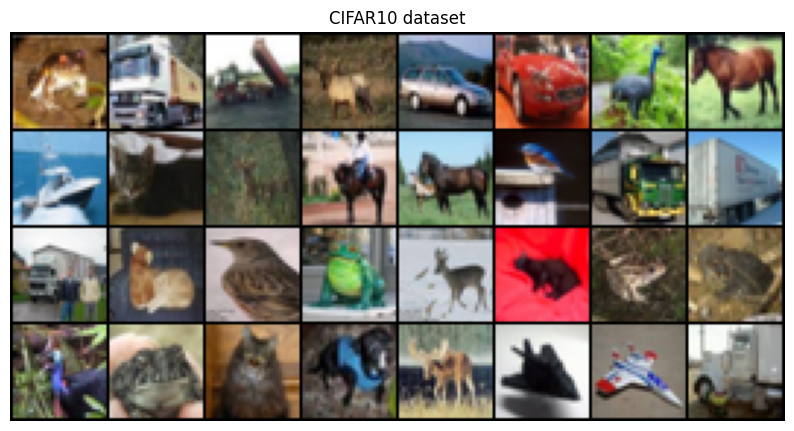

In [4]:
from torchvision.utils import make_grid

sample = next(iter(dataset_loader))['input']
img = make_grid(sample[:32], nrow=8, padding=1, normalize=True, scale_each=False, pad_value=0)

plt.figure(figsize=(10,10))
plt.imshow(img.permute(1, 2, 0))
plt.title('CIFAR10 dataset')
plt.axis('off')
plt.show()

## Optics forward model
Define the forward operators $\mathbf{y} = \mathbf{H}_\phi \mathbf{x}$, in this case, the CASSI and SPC forward models.  
Each optics model can comptute the forward and backward operators i.e., $\mathbf{y} = \mathbf{H}_\phi \mathbf{x}$ and $\mathbf{x} = \mathbf{H}^T_\phi \mathbf{y}$.



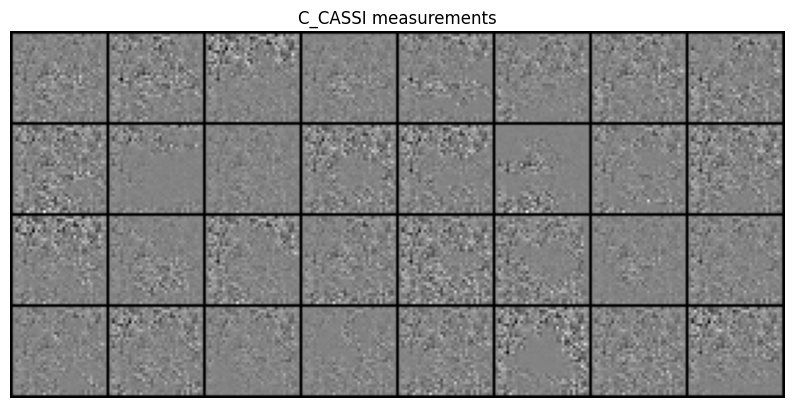

In [5]:
import math
from colibri.optics import SPC, SD_CASSI, DD_CASSI, C_CASSI

img_size = sample.shape[1:]

acquisition_config = dict(
    input_shape = img_size,
)

if acquisition_name == 'spc':
    n_measurements  = 256
    n_measurements_sqrt = int(math.sqrt(n_measurements))
    acquisition_config['n_measurements'] = n_measurements

acquisition_model = {
    'spc': SPC(**acquisition_config),
    'sd_cassi': SD_CASSI(**acquisition_config),
    'dd_cassi': DD_CASSI(**acquisition_config),
    'c_cassi': C_CASSI(**acquisition_config)
}[acquisition_name]

y = acquisition_model(sample)

if acquisition_name == 'spc':
    y = y.reshape(y.shape[0], -1, n_measurements_sqrt, n_measurements_sqrt)

img = make_grid(y[:32], nrow=8, padding=1, normalize=True, scale_each=False, pad_value=0)

plt.figure(figsize=(10,10))
plt.imshow(img.permute(1, 2, 0))
plt.axis('off')
plt.title(f'{acquisition_name.upper()} measurements')
plt.show()

## Reconstruction model
Define the recovery model $\mathbf{x} = \mathcal{G}_\theta( \mathbf{y})$, in this case, a simple U-Net model.
You can add you custom model by using the :meth: `build_network` function.
Additionally we define the end-to-end model that combines the forward and recovery models.
Define the loss function $\mathcal{L}$, and the regularizers $\mathcal{R}$ for the forward and recovery models.



In [8]:
from colibri.models import build_network, Unet, Autoencoder
from colibri.misc import E2E
from colibri.train import Training
from colibri.metrics import psnr, ssim
from colibri.regularizers import (
    Binary,
    Transmittance,
    MinVariance,
    KLGaussian,
)


network_config = dict(
    in_channels=sample.shape[1],
    out_channels=sample.shape[1],
    reduce_spatial = True           # Only for Autoencoder
)

recovery_model = build_network(Unet, **network_config)

model = E2E(acquisition_model, recovery_model)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
losses = {"MSE": torch.nn.MSELoss(), "L1": torch.nn.L1Loss()}
metrics = {"PSNR": psnr, "SSIM": ssim}
losses_weights = [1.0, 1.0]

n_epochs = 10
steps_per_epoch = 10
frequency = 1
regularizers_optics_ce = {"RB": Binary(), "RT": Transmittance()}
regularizers_optics_ce_weights = [50, 1]

regularizers_optics_mo = {"MV": MinVariance(), "KLG": KLGaussian(stddev=0.1)}
regularizers_optics_mo_weights = [1e-3, 0.1]

train_schedule = Training(
    model=model,
    train_loader=dataset_loader,
    optimizer=optimizer,
    loss_func=losses,
    losses_weights=losses_weights,
    metrics=metrics,
    regularizers=None,
    regularization_weights=None,
    schedulers=[],
    callbacks=[],
    device=device,
    regularizers_optics_ce=regularizers_optics_ce,
    regularization_optics_weights_ce=regularizers_optics_ce_weights,
    regularizers_optics_mo=regularizers_optics_mo,
    regularization_optics_weights_mo=regularizers_optics_mo_weights,
)


results = train_schedule.fit(
    n_epochs=n_epochs, steps_per_epoch=steps_per_epoch, freq=frequency
)

Train :: Epoch: 10/10:   3%|▎         | 11/391 [00:21<12:33,  1.98s/it, s=MSE: 0.01, L1: 0.05, , RB: 6278391.50, RT: 6.09, , MV: 0.01, KLG: 4.99, , PSNR: 22.55, SSIM: 0.75,]


## Visualize results
Performs the inference $\tilde{\mathbf{x}} = \mathcal{G}_{\theta^*}( \mathbf{H}_{\phi^*}\mathbf{x})$ and visualize the results.



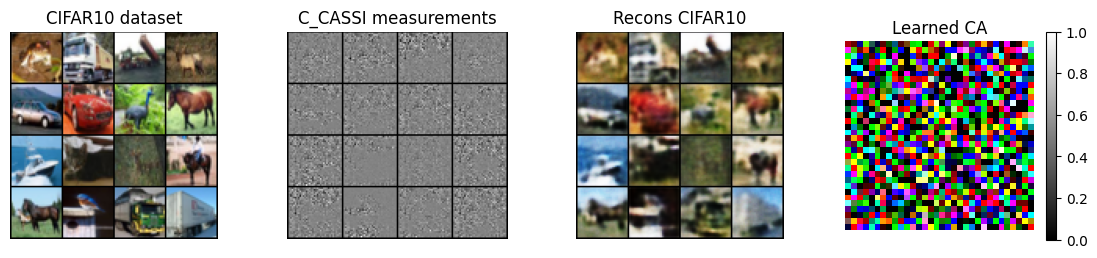

In [9]:
x_est = model(sample.to(device)).cpu()
y = acquisition_model(sample.to(device)).cpu()

if acquisition_name == 'spc':
    y = y.reshape(y.shape[0], -1, n_measurements_sqrt, n_measurements_sqrt)

img      = make_grid(sample[:16], nrow=4, padding=1, normalize=True, scale_each=False, pad_value=0)
img_est  = make_grid(x_est[:16], nrow=4, padding=1, normalize=True, scale_each=False, pad_value=0)
img_y    = make_grid(y[:16], nrow=4, padding=1, normalize=True, scale_each=False, pad_value=0)

imgs_dict = {
    "CIFAR10 dataset": img,
    f"{acquisition_name.upper()} measurements": img_y,
    "Recons CIFAR10": img_est
}

plt.figure(figsize=(14, 2.7))

for i, (title, img) in enumerate(imgs_dict.items()):
    plt.subplot(1, 4, i+1)
    plt.imshow(img.permute(1, 2, 0))
    plt.title(title)
    plt.axis('off')

ca = acquisition_model.learnable_optics.cpu().detach().numpy().squeeze()
if acquisition_name == 'spc':
    ca = ca = ca.reshape(n_measurements, 32, 32, 1)[0]
elif acquisition_name == 'c_cassi':
    ca = ca.transpose(1, 2, 0)
plt.subplot(1, 4, 4)
plt.imshow(ca, cmap='gray')
plt.axis('off')
plt.title('Learned CA')
plt.colorbar()

plt.show()